# Project title: Customer Churn Prediction in a Subscription-Based Service


---

## Project Overview

Telecommunication and subscription-based companies rely heavily on churn prediction models to retain customers. This project builds an end-to-end ML pipeline to classify customers as "likely to churn" or "likely to stay," using tabular data that combines demographic, behavioral, and usage features.

**Dataset:** Telco Customer Churn (Kaggle) - `WA_Fn-UseC_-Telco-Customer-Churn.csv`

In [1]:
# Imports & Settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

---
# Task 1: Exploratory Data Analysis (EDA)

**Objectives:**
- Analyzing dataset structure: distributions, outliers, skewness
- Examining correlations among numerical features
- Exploring categorical feature cardinality
- Studying churn vs. non-churn population imbalance
- Identifying missing values and propose imputation strategies

In [2]:
# Loading Dataset
df = pd.read_csv("../data/Telco-Customer-Churn.csv")
print(f"Dataset Shape: {df.shape}")
print(f"Number of Rows: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")

df.head()

Dataset Shape: (7043, 21)
Number of Rows: 7043
Number of Columns: 21


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Dataset Overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


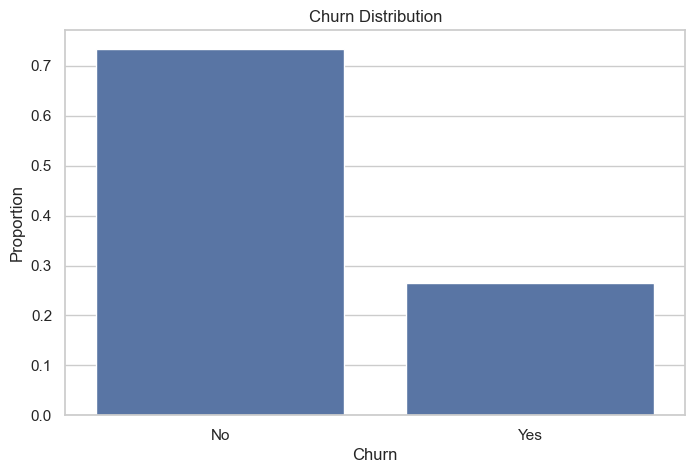

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [4]:
# Target Variable Distribution
churn_counts = df["Churn"].value_counts(normalize=True)

sns.barplot(
    x=churn_counts.index,
    y=churn_counts.values
)
plt.title("Churn Distribution")
plt.ylabel("Proportion")
plt.show()

print(churn_counts)

In [5]:
# Fixing TotalCharges
df["TotalCharges"] = pd.to_numeric(
    df["TotalCharges"], errors="coerce"
)

# print(df["TotalCharges"].isna().sum())

In [6]:
# Inspecting Missing Values
missing_total_charges = df["TotalCharges"].isna().sum()

print(
    f"After converting TotalCharges to numeric, "
    f"{missing_total_charges} values could not be parsed and were set to NaN."
)

After converting TotalCharges to numeric, 11 values could not be parsed and were set to NaN.


In [7]:
# Inspecting missing values and examining whether missing TotalCharges correspond to specific customer characteristics
df.isna().sum() 
df[df["TotalCharges"].isna()][["tenure", "MonthlyCharges", "TotalCharges"]].head()

,tenure,MonthlyCharges,TotalCharges
488,0,52.55,NaN
753,0,20.25,NaN
936,0,80.85,NaN
1082,0,25.75,NaN
1340,0,56.05,NaN


In [8]:
# Handling Missing Values
before_shape = df.shape
df = df.dropna(subset=["TotalCharges"])
after_shape = df.shape

print(f"Rows before removal: {before_shape[0]}, rows after removal: {after_shape[0]}")


Rows before removal: 7043, rows after removal: 7032


In [9]:
# Numerical Feature Distributions
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]

df[numeric_features].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


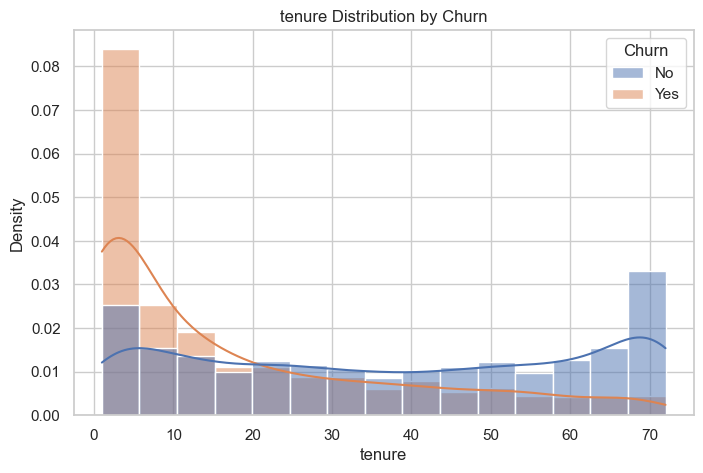

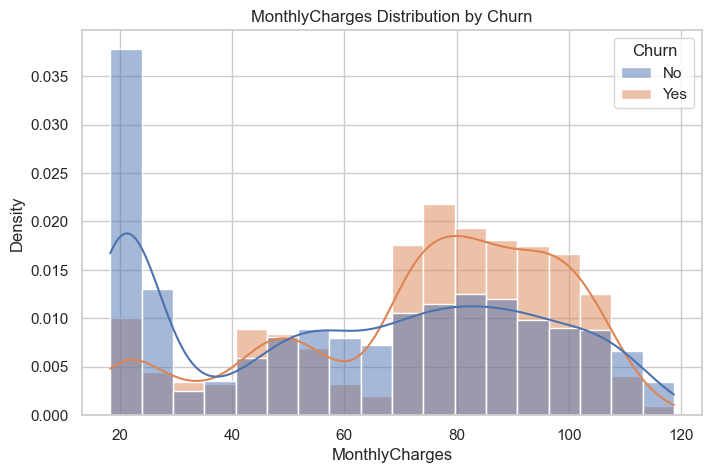

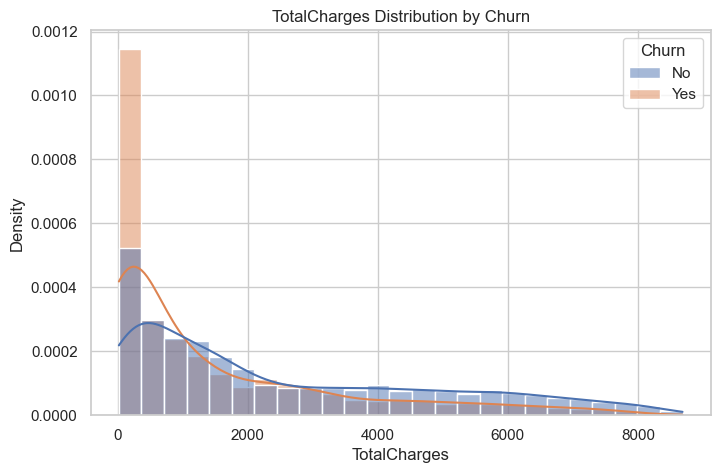

In [10]:
# Numerical Distributions by Churn
for col in numeric_features:
    sns.histplot(
        data=df,
        x=col,
        hue="Churn",
        kde=True,
        stat="density",
        common_norm=False
    )
    plt.title(f"{col} Distribution by Churn")
    plt.show()

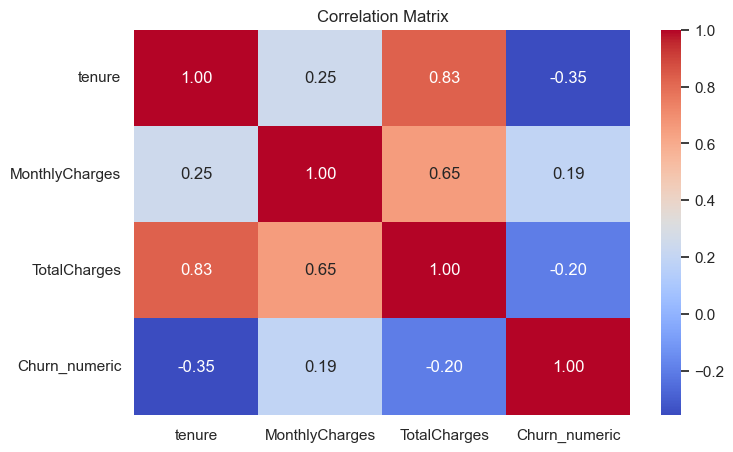

In [11]:
# Correlation Analysis
df["Churn_numeric"] = df["Churn"].map({"No": 0, "Yes": 1})
corr = df[numeric_features + ["Churn_numeric"]].corr()
# corr = df[numeric_features + ["Churn"]].corr()

sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Matrix")
plt.show()

In [12]:
# Categorical Feature Cardinality
categorical_features = df.select_dtypes(include="object").columns

for col in categorical_features:
    print(f"{col}: {df[col].nunique()} unique values")

customerID: 7032 unique values
gender: 2 unique values
Partner: 2 unique values
Dependents: 2 unique values
PhoneService: 2 unique values
MultipleLines: 3 unique values
InternetService: 3 unique values
OnlineSecurity: 3 unique values
OnlineBackup: 3 unique values
DeviceProtection: 3 unique values
TechSupport: 3 unique values
StreamingTV: 3 unique values
StreamingMovies: 3 unique values
Contract: 3 unique values
PaperlessBilling: 2 unique values
PaymentMethod: 4 unique values
Churn: 2 unique values


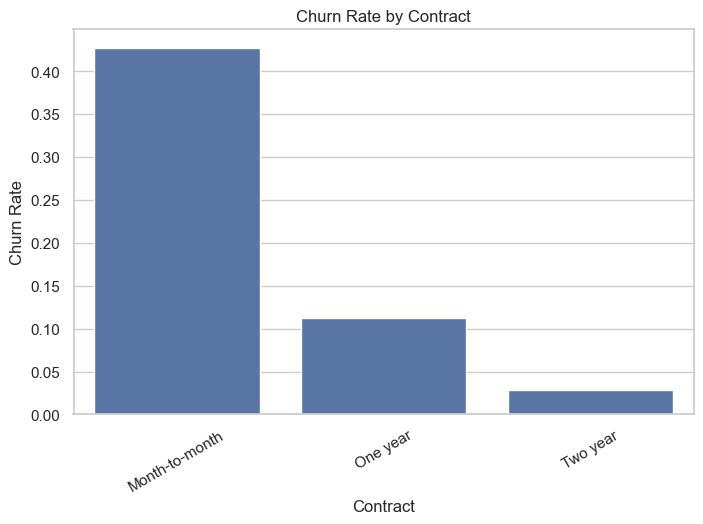

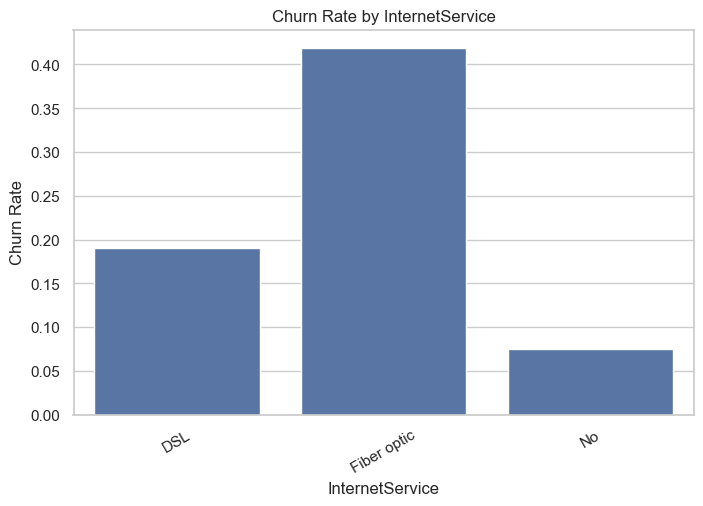

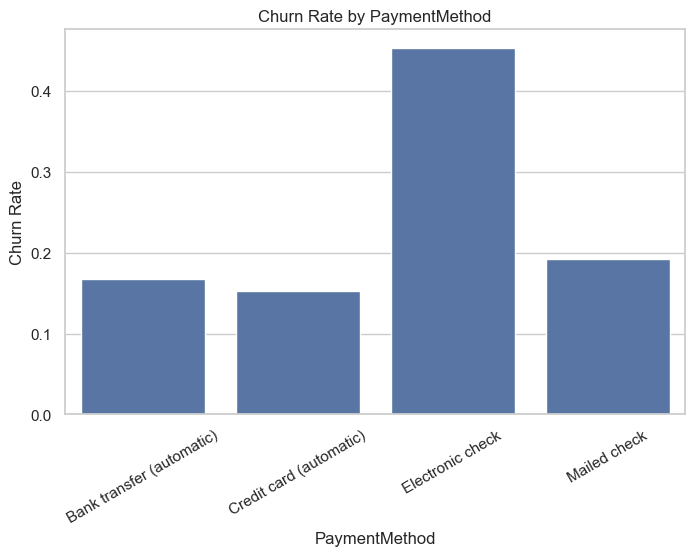

In [13]:
# Churn Rate by Key Categorical Features
key_cats = ["Contract", "InternetService", "PaymentMethod"]

for col in key_cats:
    churn_rate = (
        df.groupby(col)["Churn"]
        .value_counts(normalize=True)
        .rename("rate")
        .reset_index()
    )

    sns.barplot(
        data=churn_rate[churn_rate["Churn"] == "Yes"],
        x=col,
        y="rate"
    )
    plt.title(f"Churn Rate by {col}")
    plt.ylabel("Churn Rate")
    plt.xticks(rotation=30)
    plt.show()

<!-- Summary of EDA Findings -->
### EDA Summary

- The dataset exhibits moderate class imbalance, with approximately 26–27% churned customers.
- Customers with short tenure are significantly more likely to churn.
- Month-to-month contracts show substantially higher churn rates than long-term contracts.
- Numerical features show mild skewness but no extreme outliers.
- Categorical features have low cardinality, making one-hot encoding appropriate.
- Missing values in TotalCharges correspond to customers with very low tenure and were removed.